# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-1"}
    download(args)
    extract("data/Model_I.tgz", "data/")
    extract("data/Model_I_test.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV
From (redirected): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV&confirm=t&uuid=50369c86-3a81-4cd8-8305-3182ce2d9e87
To: /opt/repo/GSoC-23/data/Model_I.tgz
100%|██████████| 1.99G/1.99G [00:34<00:00, 57.3MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1
From (redirected): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1&confirm=t&uuid=b38169b4-19fb-4c45-a09b-235fb366961b
To: /opt/repo/GSoC-23/data/Model_I_test.tgz
100%|██████████| 340M/340M [00:09<00:00, 37.6MB/s]


In [2]:
import gc
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
def npy_loader(path):
    if 'axion' in path:
        sample = np.load(path, allow_pickle=True)[0]
    else:
        sample = np.load(path, allow_pickle=True)
    sample = 255 * (sample / sample.max())
    sample = Image.fromarray(sample.astype('uint8')).convert("RGB")
    return sample
    

trainset = datasets.DatasetFolder(
    root='data/Model_I',
    loader=npy_loader,
    extensions=['.npy'],
    transform = train_transforms
)

testset = datasets.DatasetFolder(
    root='data/Model_I_test',
    loader=npy_loader,
    extensions=['.npy'],
    transform = test_transforms
)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [5]:
lr = 0.0001
epochs = 30
gamma = 0.5
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [6]:
from models import coordinates, networks, transformers, ET

tf_default_opts = {
    "in_channels": 1,
    "kernel_size": 3,
    "nf": 32,
    "strides": (2, 1),
}

# classification network defaults
net_default_opts = {
    "input_channels": 1,
    "output_size": 3,
    "nf": 32,
    "p_dropout": 0.3,
    "pad_mode": (None, "cyclic"),
    "pool": (True, True, False),
}

ET_ = ET(
    tfs=[
        transformers.ShearX,
        transformers.HyperbolicRotation,
        transformers.PerspectiveX,
        transformers.PerspectiveY,
    ],
    coords=coordinates.logpolar_grid,
    net=networks.BasicCNN,
    equivariant=True,
    tf_opts=tf_default_opts,
    net_opts=net_default_opts,
)
ET_.model = ET_.model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(ET_.model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)

# Training


In [7]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0, 0
    ET_.model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    _ep = 0
    for data, label in tqdm(train_loader):
        if _ep%100 == 0:
            torch.cuda.empty_cache()
            gc.collect()
        data = data.to(device)
        label = label.to(device)

        output = ET_.model(data)
        loss = criterion(output, label)
        tr_loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total += len(label)

        epoch_loss += loss.item() / len(train_loader)
        _ep += 1
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct / total * 100)
    epoch_accuracy = (correct / total) * 100
    correct, total = 0, 0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = ET_.model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)

            epoch_val_loss += val_loss / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct / total * 100)
    epoch_val_accuracy = (correct / total) * 100

    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(ET_)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
ET_._save("equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 235/235 [00:29<00:00,  7.99it/s]


Epoch : 1 - loss : 1.0953 - acc: 37.2237% - val_loss : 1.0792 - val_acc: 39.9533%


100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


Epoch : 2 - loss : 1.0742 - acc: 40.1280% - val_loss : 1.0617 - val_acc: 42.2267%


100%|██████████| 235/235 [00:29<00:00,  7.97it/s]


Epoch : 3 - loss : 1.0466 - acc: 43.1408% - val_loss : 1.0272 - val_acc: 44.9133%


100%|██████████| 235/235 [00:28<00:00,  8.22it/s]


Epoch : 4 - loss : 0.9966 - acc: 46.8563% - val_loss : 0.9443 - val_acc: 50.1933%


100%|██████████| 235/235 [00:28<00:00,  8.25it/s]


Epoch : 5 - loss : 0.8906 - acc: 54.4439% - val_loss : 0.8379 - val_acc: 58.2867%


100%|██████████| 235/235 [00:28<00:00,  8.15it/s]


Epoch : 6 - loss : 0.8326 - acc: 58.9237% - val_loss : 0.7645 - val_acc: 63.9600%


100%|██████████| 235/235 [00:28<00:00,  8.13it/s]


Epoch : 7 - loss : 0.7326 - acc: 66.9317% - val_loss : 0.6263 - val_acc: 73.8667%


100%|██████████| 235/235 [00:28<00:00,  8.24it/s]


Epoch : 8 - loss : 0.6174 - acc: 74.3867% - val_loss : 0.5317 - val_acc: 78.8000%


100%|██████████| 235/235 [00:28<00:00,  8.12it/s]


Epoch : 9 - loss : 0.5560 - acc: 77.6075% - val_loss : 0.5030 - val_acc: 80.0600%


100%|██████████| 235/235 [00:28<00:00,  8.12it/s]


Epoch : 10 - loss : 0.5177 - acc: 79.4664% - val_loss : 0.4398 - val_acc: 83.1867%


100%|██████████| 235/235 [00:28<00:00,  8.23it/s]


Epoch : 11 - loss : 0.4547 - acc: 82.4119% - val_loss : 0.4067 - val_acc: 84.4667%


100%|██████████| 235/235 [00:28<00:00,  8.16it/s]


Epoch : 12 - loss : 0.4348 - acc: 83.2528% - val_loss : 0.4069 - val_acc: 84.6667%


100%|██████████| 235/235 [00:30<00:00,  7.75it/s]


Epoch : 13 - loss : 0.4221 - acc: 83.8720% - val_loss : 0.3755 - val_acc: 86.2467%


100%|██████████| 235/235 [00:28<00:00,  8.26it/s]


Epoch : 14 - loss : 0.4110 - acc: 84.3965% - val_loss : 0.3597 - val_acc: 86.7333%


100%|██████████| 235/235 [00:29<00:00,  8.07it/s]


Epoch : 15 - loss : 0.3990 - acc: 84.7381% - val_loss : 0.3545 - val_acc: 86.9067%


100%|██████████| 235/235 [00:28<00:00,  8.17it/s]


Epoch : 16 - loss : 0.3865 - acc: 85.3482% - val_loss : 0.3457 - val_acc: 87.0933%


100%|██████████| 235/235 [00:28<00:00,  8.18it/s]


Epoch : 17 - loss : 0.3778 - acc: 85.6601% - val_loss : 0.3278 - val_acc: 87.7000%


100%|██████████| 235/235 [00:28<00:00,  8.16it/s]


Epoch : 18 - loss : 0.3620 - acc: 86.3330% - val_loss : 0.3104 - val_acc: 88.3533%


100%|██████████| 235/235 [00:28<00:00,  8.20it/s]


Epoch : 19 - loss : 0.3584 - acc: 86.4839% - val_loss : 0.3060 - val_acc: 88.7067%


100%|██████████| 235/235 [00:28<00:00,  8.22it/s]


Epoch : 20 - loss : 0.3502 - acc: 86.5924% - val_loss : 0.2979 - val_acc: 88.9600%


100%|██████████| 235/235 [00:28<00:00,  8.19it/s]


Epoch : 21 - loss : 0.3289 - acc: 87.5350% - val_loss : 0.2794 - val_acc: 89.5667%


100%|██████████| 235/235 [00:28<00:00,  8.17it/s]


Epoch : 22 - loss : 0.3218 - acc: 87.8892% - val_loss : 0.2946 - val_acc: 89.0400%


100%|██████████| 235/235 [00:28<00:00,  8.16it/s]


Epoch : 23 - loss : 0.3199 - acc: 88.0263% - val_loss : 0.2768 - val_acc: 89.6067%


100%|██████████| 235/235 [00:28<00:00,  8.21it/s]


Epoch : 24 - loss : 0.3151 - acc: 88.0137% - val_loss : 0.2711 - val_acc: 89.9200%


100%|██████████| 235/235 [00:28<00:00,  8.23it/s]


Epoch : 25 - loss : 0.3115 - acc: 88.1748% - val_loss : 0.2661 - val_acc: 90.0600%


100%|██████████| 235/235 [00:28<00:00,  8.36it/s]


Epoch : 26 - loss : 0.3074 - acc: 88.4502% - val_loss : 0.2642 - val_acc: 90.3200%


100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


Epoch : 27 - loss : 0.3057 - acc: 88.4970% - val_loss : 0.2765 - val_acc: 89.6133%


100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


Epoch : 28 - loss : 0.3024 - acc: 88.6147% - val_loss : 0.2529 - val_acc: 90.6667%


100%|██████████| 235/235 [00:28<00:00,  8.39it/s]


Epoch : 29 - loss : 0.2977 - acc: 88.7209% - val_loss : 0.2601 - val_acc: 90.0867%


100%|██████████| 235/235 [00:28<00:00,  8.21it/s]

Epoch : 30 - loss : 0.2976 - acc: 88.8432% - val_loss : 0.2500 - val_acc: 90.8733%


# Plotting Loss and Accuracy


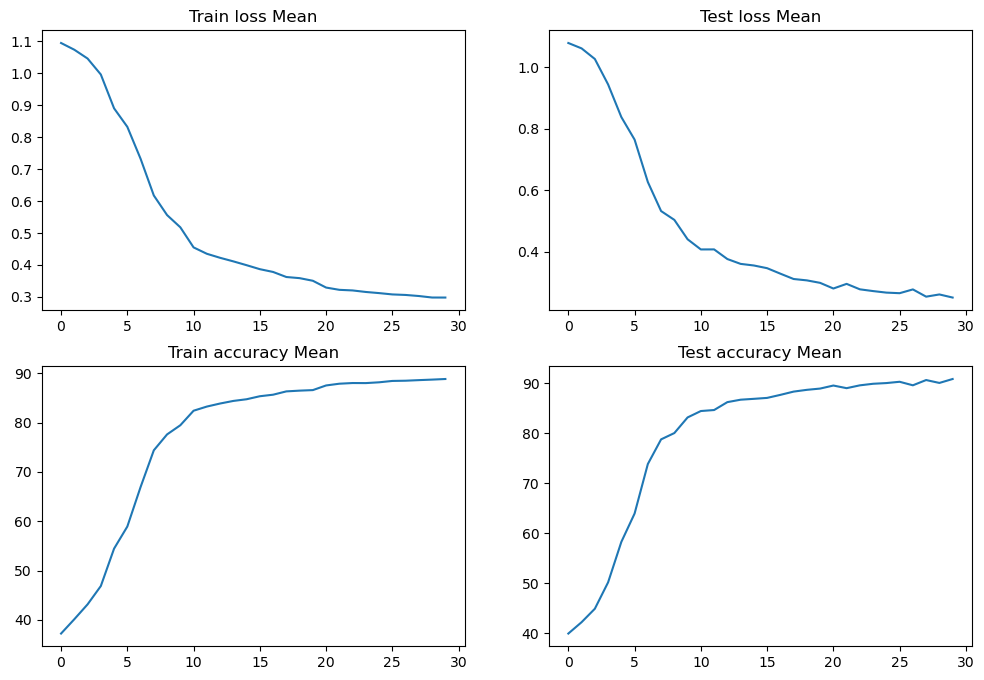

In [8]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title("Train accuracy Mean")
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title("Test accuracy Mean")
plt.plot(all_test_accuracy)

# Loading Best Model


In [9]:
ET_ = ET(
    tfs=[
        transformers.ShearX,
        transformers.HyperbolicRotation,
        transformers.PerspectiveX,
        transformers.PerspectiveY,
    ],
    coords=coordinates.logpolar_grid,
    net=networks.BasicCNN,
    equivariant=True,
    tf_opts=tf_default_opts,
    net_opts=net_default_opts,
    load_path="equi_nn.pth",
)
ET_.model = ET_.model.to(device)

# Testing


In [10]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    ET_.model.eval()
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = ET_.model(x)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 235/235 [00:26<00:00,  8.81it/s]


# Confusion Matrix


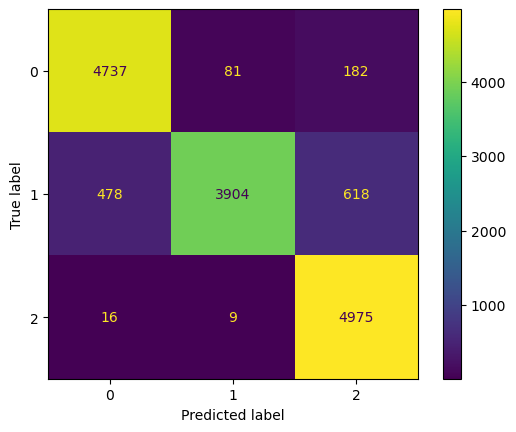

In [11]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_label, pred_label)).plot()

# AUC Score


In [12]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [13]:
roc_auc_score(np.array(true_label),[softmax(i) for i in np.array(pred_score)], multi_class='ovr')

0.9833281333333335

# ROC-CURVE


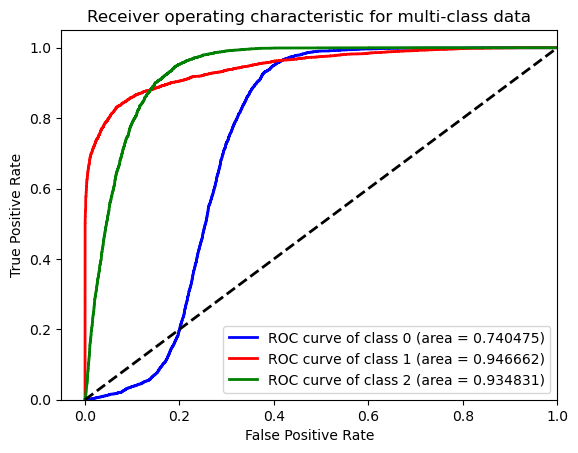

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()